In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.corpus import words as english_words
nltk.download('stopwords')
nltk.download('words')


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from joblib import dump, load

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


## Casino List
- https://www.casinoslists.com/casinos/best
- https://www.casinofreak.com/reviews/all-online-casinos
- https://casinoalpha.com/online-casinos/list/page/2/
- https://www.nonstopbonus.com/new-online-casinos
- https://list.casino/
- https://lcb.org/casinos

In [2]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
    'Accept-Language': 'en-US,en;q=0.9',
    'Connection': 'keep-alive'
}

In [3]:
df_pos = pd.read_csv('data/positives_clean.csv', lineterminator='\n')
df_neg = pd.read_csv('data/negatives_clean.csv', lineterminator='\n')

df_pos['label'] = 1
df_neg['label'] = 0

df = pd.concat([df_pos, df_neg], ignore_index=True)
df

,text,label
0,SISportsbook | Sports Betting Odds | Bet $10 G...,1
1,Online Sportsbook | Bet Online | Online Sports...,1
2,FanDuel | Daily Fantasy Sports and Online U.S....,1
3,To view this video please enable JavaScript an...,1
4,web browser that,1
...,...,...
3417,Free Podcast Hosting - Buzzsprout Buzzsprout m...,0
3418,ORCID Please enable JavaScript to continue usi...,0
3419,Discover Top Blogs & Best Websites in 2023 - F...,0
3420,Google AR & VR | Home OverviewNews & Announcem...,0


In [4]:
print("len", len(df))
df['text'] = df['text'].apply(lambda x: x.lower())
df.loc[:, 'word_count'] = df['text'].str.split().str.len()
df = df[df['word_count'] >= 30]
df = df.drop(columns=['word_count'])
print("len", len(df))
df

len 3422
len 1070


,text,label
0,sisportsbook | sports betting odds | bet $10 g...,1
1,online sportsbook | bet online | online sports...,1
2,fanduel | daily fantasy sports and online u.s....,1
5,supports html5 videoskipnew customersbet $5 ge...,1
6,malta sunsetsign inbeginning on 22 january 202...,1
...,...,...
3416,online community for artists [pixiv] pixiv has...,0
3417,free podcast hosting - buzzsprout buzzsprout m...,0
3419,discover top blogs & best websites in 2023 - f...,0
3420,google ar & vr | home overviewnews & announcem...,0


In [5]:
print("num datapoints", len(df))
print("num positive datapoints", len(df[df['label'] == 1]))
print("num negative datapoints", len(df[df['label'] == 0]))

num_positive = len(df[df['label'] == 1])
num_negative = len(df[df['label'] == 0])

min_samples = min(num_positive, num_negative)

# Undersample
df_positive = df[df['label'] == 1].sample(n=min_samples, random_state=42)
df_negative = df[df['label'] == 0].sample(n=min_samples, random_state=42)

# Concatenate the undersampled dataframes
df_balanced = pd.concat([df_positive, df_negative], ignore_index=True)

print("-----------------------------------------------------------")
print("num datapoints", len(df_balanced))
print("num positive datapoints", len(df_balanced[df_balanced['label'] == 1]))
print("num negative datapoints", len(df_balanced[df_balanced['label'] == 0]))

df_balanced

num datapoints 1070
num positive datapoints 346
num negative datapoints 724
-----------------------------------------------------------
num datapoints 692
num positive datapoints 346
num negative datapoints 346


,text,label
0,csgoace.com is for sale | hugedomainsskip to m...,1
1,bet2290.com is for sale | hugedomainsskip to m...,1
2,goalwin.com domain name is for sale. inquire n...,1
3,join now get paid when you win - faster than e...,1
4,uk bingo reviews news bonus offers & promotion...,1
...,...,...
687,health: trusted and empathetic health and well...,0
688,monster jobs - job search career advice & hiri...,0
689,lifehacker | do everything better skip to main...,0
690,apple developer view in english global nav ope...,0


In [6]:
X = df["text"]
y = df["label"]
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size=0.3, random_state=42)

train_df = pd.concat([pd.DataFrame(X_train_df, columns=["text"]), pd.DataFrame(y_train_df, columns=["label"])], axis=1)
test_df = pd.concat([pd.DataFrame(X_test_df, columns=["text"]), pd.DataFrame(y_test_df, columns=["label"])], axis=1)

train_df, test_df

(                                                   text  label
 1319  google chrome - the fast & secure web browser ...      0
 1356  federal trade commission | protecting america'...      0
 1401  \t\t footer links fda archive about fda access...      0
 2158  martha stewart | recipes diy home decor & craf...      0
 1257  dropbox.com skip to main contentwhy dropbox?ov...      0
 ...                                                 ...    ...
 991   casino online sportsbooktoggle navigationlogin...      1
 1358  about.me | your personal homepageget your free...      0
 370   fanduel | daily fantasy sports and online u.s....      1
 3290  olympics | olympic games medals results & late...      0
 2506  oprah.com oprah.com own for the holidays own f...      0
 
 [749 rows x 2 columns],
                                                    text  label
 2037  7975000+ free and premium vector icons illustr...      0
 2018  learn more featured move fast think slow: how ...      0
 197   betpci

In [7]:
stop_words = set(stopwords.words('english'))
words = train_df['text'].str.split(expand=True).stack()
words = words[~words.isin(stop_words)]

# Calculate word frequency
word_freq = words.value_counts().reset_index()
word_freq.columns = ['word', 'freq']
word_freq

,word,freq
0,de,2995
1,&,2974
2,online,1943
3,new,1598
4,-,1586
...,...,...
97970,zak!/walmart,1
97971,kindi,1
97972,kids/amazonisrael-gaza,1
97973,conflict:,1


In [8]:
# Remove non-English words
print("num words before:", len(word_freq))
english = set(english_words.words())
new_word_freq = word_freq[word_freq['word'].isin(english) & (word_freq['word'].str.len() >= 3)]
print("num words after:", len(new_word_freq))

num words before: 97975
num words after: 11000


In [9]:
# Remove words with frequency less than 10
print("num words before:", len(new_word_freq))
new_word_freq = new_word_freq[new_word_freq['freq'] >= 10]
print("num words after:", len(new_word_freq))

num words before: 11000
num words after: 2915


In [10]:
bag_of_words = new_word_freq['word'].tolist()

with open('bag_of_words.txt', 'w') as file:
    for word in bag_of_words:
        file.write(word + '\n')

In [11]:
def create_features(df):
    df['features'] = None
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
        text = row['text']
        website_words = text.split()
        website_words = list(dict.fromkeys(website_words))
        features_local = [1 if w in website_words else 0 for w in bag_of_words]
        df.at[idx, 'features'] = features_local
    return df
train_df = create_features(train_df)
test_df = create_features(test_df)
train_df

Processing rows:  59%|█████▉    | 444/749 [00:07<00:05, 59.10it/s]


KeyboardInterrupt: 

In [16]:
X_train = np.array(train_df['features'].tolist())
y_train = np.array(train_df['label'].tolist())

X_test = np.array(test_df['features'].tolist())
y_test = np.array(test_df['label'].tolist())


# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SVM regularization parameter
C = 1.0

# Create different SVM models
svc = SVC(kernel='linear', C=C, probability=True).fit(X_train, y_train)
poly_svc = SVC(kernel='poly', degree=3, C=C).fit(X_train, y_train)

# Evaluate model
accuracy_lin = svc.score(X_test, y_test)
accuracy_poly = poly_svc.score(X_test, y_test)
print(f"Lin Accuracy: {accuracy_lin * 100:.2f}%")
print(f"POLY Accuracy: {accuracy_poly * 100:.2f}%")

Lin Accuracy: 90.34%
POLY Accuracy: 70.72%


In [19]:
# save model weights
dump(svc, 'weights.joblib')

['weights.joblib']

In [345]:
# for plot later
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_test)

y_pred_linear = svc.predict(X_test)
y_pred_poly = poly_svc.predict(X_test)

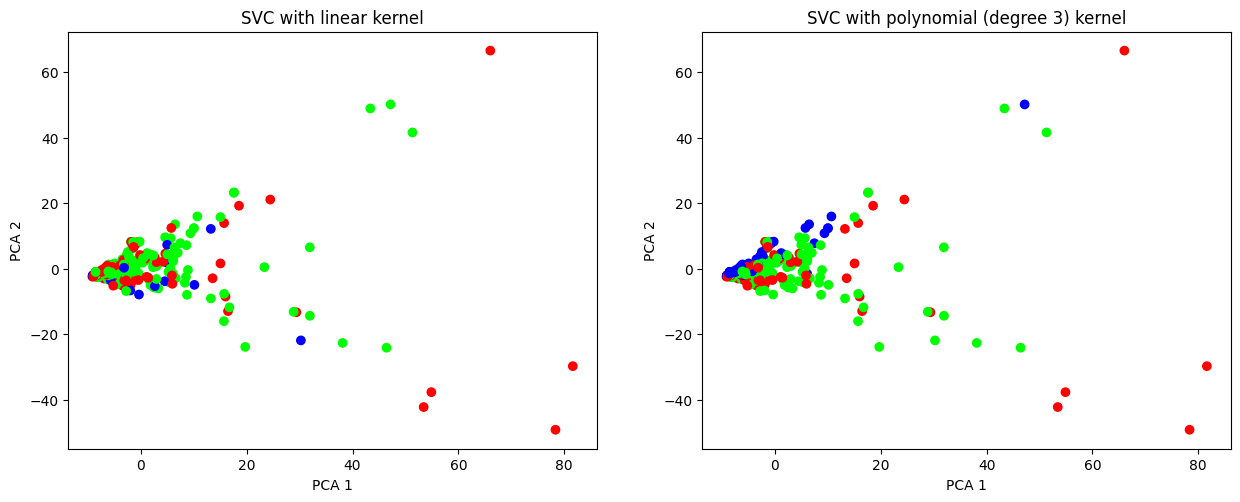

In [346]:
def repaint_scatter(y):
    for idx in range(len(y)):
        if y[idx] == 1: # incorrect
            y[idx] = -1
        else: # correct
            if y_train[idx] == 1: # casino
                y[idx] = 0
            else: # not casino
                y[idx] = 1
    return y
    
# Titles for the plots
titles = ['SVC with linear kernel',
          'SVC with polynomial (degree 3) kernel']

# Set the figure size
plt.figure(figsize=(15, 13))

# Plotting the decision boundaries on the reduced dataset
for i, clf in enumerate((svc, poly_svc)):
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.2, hspace=0.4)

    # # Apply PCA transformation to the meshgrid
    # xx, yy = np.meshgrid(np.linspace(X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1, 50),
    #                      np.linspace(X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1, 50))
    # Z = clf.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    # Z = Z.reshape(xx.shape)

    # # Contour plot
    # plt.contourf(xx, yy, Z, cmap=plt.cm.brg, alpha=0.8)

    # Scatter plot of the reduced data
    y = None
    if i == 0:
        y = repaint_scatter(np.abs(y_test - y_pred_linear))
    else:
        y = repaint_scatter(np.abs(y_test - y_pred_poly))
    
    # green: correctly classified and normal website
    # red: correctly classified and casino website
    # blue: incorrectly classified
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap=plt.cm.brg)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title(titles[i])

plt.show()

### Predict

In [15]:
url = "https://en.wikipedia.org/wiki/Casino_(video_game)"

response = requests.get(url, headers=headers)
txt = ""
if response.ok:
    soup = BeautifulSoup(response.content, 'html.parser')
    txt = soup.get_text().replace("\n", " ")
txt

'    Casino (video game) - Wikipedia                                    Jump to content        Main menu      Main menu move to sidebar hide    \t\tNavigation \t   Main pageContentsCurrent eventsRandom articleAbout WikipediaContact usDonate      \t\tContribute \t   HelpLearn to editCommunity portalRecent changesUpload file      Languages  Language links are at the top of the page.                    Search            Search                              Create account  Log in         Personal tools       Create account Log in      \t\tPages for logged out editors learn more    ContributionsTalk                             Contents move to sidebar hide     (Top)      1Gameplay        2Legacy        3References        4See also        5External links                  Toggle the table of contents        Casino (video game)    Add languages      Add links            ArticleTalk      English                  ReadEditView history        Tools      Tools move to sidebar hide    \t\tActions \t 

In [16]:
txt_clean = txt.lower()
txt_clean = txt_clean.split()
txt_clean = list(set(txt_clean))
txt_clean = ' '.join(txt_clean)

df_predict = pd.DataFrame([txt_clean], columns=['text'])

bag_of_words = []
with open('bag_of_words.txt', 'r') as file:
    bag_of_words = file.readlines()
bag_of_words = [word.strip() for word in bag_of_words]
df_predict = create_features(df_predict)

feature_vec = np.array(df_predict['features'].tolist())

Processing rows: 100%|██████████| 1/1 [00:00<00:00, 67.01it/s]


In [17]:
svm = load('weights.joblib')

label = svm.predict(feature_vec)
prob = svm.predict_proba(feature_vec)
label[0], prob[0]

(0, array([0.67212281, 0.32787719]))